### 1. Модель без марковского переключения

### Модель и обозначения: 
$$y_t = \alpha + \epsilon_t$$
$$\epsilon_t = \sigma_t z_t$$
$$z_t \sim iid \mathcal{N}(0, 1)$$
$$\sigma_t^2 = \beta_0 + \beta_1 \epsilon_{t-1}^2 + \gamma \sigma_{t-1}^2$$


### Задача:
Дано: $(y_0, y_2, ..., y_T) = Y$ 

Оценить параметры $(\alpha, \beta_0, \beta_1, \gamma) = \theta$


In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm
import math as m
import matplotlib.pyplot as plt 

правдоподобие: 
$$L(\theta| Y) = \Pi_{t = 1}^T (2\pi \sigma_t^2)^{-1/2} \exp(-\frac{1}{2\sigma_t^2}(y_t - \alpha)^2)$$ 
Надо выразить $\sigma_t$ через $y_t$ и найти argmax

$$\epsilon_t = y_t - \alpha$$
$$\sigma_t = \beta_0 + \beta_1 \epsilon_{t-1}^2 + \gamma\sigma_{t-1}^2 = \beta_0 + \beta_1 (y_{t-1} - \alpha)^2 + \gamma\sigma_{t-1}^2$$

$$\sigma_0^2 = \frac{\beta_0}{1 - \beta_1 - \gamma}$$

In [2]:
# функция выражает sigma_t по массиву y размера T 

def calc_sigmasq(t, y, theta): # y - массив значений y, T - размер массива значений, theta = параметры
    # в theta лежат параметры
    # выгружаем параметры
    alpha = theta[0]
    beta_0 = theta[1]
    beta_1 = theta[2]
    gamma = theta[3]

    sigmasq = [beta_0 / (1 - beta_1 - gamma)]
    for i in range(1, t + 1):
        sigmasq.append(beta_0 + beta_1 * (y[i - 1] - alpha)**2 + gamma * sigmasq[i - 1])
    return sigmasq

In [3]:
# надо посчитать правдоподобие при разных значениях [alpha, beta_0, beta_1, gamma] = theta и посчитать argmax

def calc_log_likelhood(t, y, theta):
    sigmasq = calc_sigmasq(t, y, theta) ## массив сигма square
    alpha = theta[0]
    logL = 0
    for i in range(t):
        add = m.log(norm.pdf(y[i], loc=alpha, scale=(sigmasq[i]**0.5))) # scale = \sqrt(var)
        logL += add
    return logL


In [4]:
def find_max_likelhood(t, y): 
    # надо сгенерировать массив параметров theta = [alpha, beta_0, beta_1, gamma] alpha \in [-1, 1], beta_0 in (0, 1], beta_1 in [0, 1], gamma in [0, 1]

    alpha_values = np.arange(-1, 1.1, 0.1)
    beta_0_values = np.arange(0.1, 1.1, 0.1)
    beta_1_values = np.arange(0, 1.1, 0.1)
    gamma_values = np.arange(0, 1.1, 0.1)

    theta_values = []
    for first in alpha_values:
        for second in beta_0_values:
            for third in beta_1_values:
                for fourth in gamma_values:
                    theta_values.append([first, second, third, fourth])


    L_values = []
    
    for theta in theta_values:
        L = calc_log_likelhood(t, y, theta)
        L_values.append(L)
    
    theta_index = np.argmax(L_values)

    return theta_values[theta_index], L_values

# find_max_likelhood(5, [0.2, 0.1, -0.02, -0.1, 0.012])


In [22]:
# генерим данные 
alpha = 0.5
beta_0 = 1
beta_1 = 0.3
gamma = 0.6 
sigma_0sq = (beta_0 / (1 - beta_1 - gamma)) # попробуем делать массив sigma^2

z = norm.rvs(loc=0, scale=1, size=1000, random_state=42) # вектор z_t

# посчитаем массив sigma, epsilon
sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0 + beta_1 * epsilon[i - 1]**2 + gamma * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

# посчитаем массив y
y = []
for i in range(len(z)):
    y.append(alpha + epsilon[i])

print(len(y))
print(len(z))
print(len(epsilon))
print(len(sigmasq))

1000
1000
1000
1000


In [7]:
from scipy.optimize import minimize

start_theta = [0.1, 0.1, 0.1, 0.1]

def optimize_function(theta):
    return -1 * calc_log_likelhood(t=1000, y=y, theta=theta)

result = minimize(optimize_function, start_theta, bounds=[(0.01, 0.6), (0, 1.5), (0, 0.34), (0, 0.64)])

print(f'Параметры после оптимизации: alpha = {result.x[0]:.4f}, beta_0 = {result.x[1]:.4f}, beta_1 = {result.x[2]:.4f}, gamma = {result.x[3]:.4f}. Log-правдоподобие: {-1 * result.fun:.4f}.')

true_log_likelhood = calc_log_likelhood(t=1000, y=y, theta=[0.5, 1, 0.3, 0.6])
print(f'Реальные параметры: alpha = {0.5}, beta_0 = {1}, beta_1 = {0.3}, gamma = {0.6}. Log-Правдоподобие при этих параметрах: {true_log_likelhood:.4f}.')

Параметры после оптимизации: alpha = 0.5438, beta_0 = 0.9123, beta_1 = 0.2468, gamma = 0.6395. Log-правдоподобие: -2352.3539.
Реальные параметры: alpha = 0.5, beta_0 = 1, beta_1 = 0.3, gamma = 0.6. Log-Правдоподобие при этих параметрах: -2353.3618.


Пробую больше данных (выборка 100к)

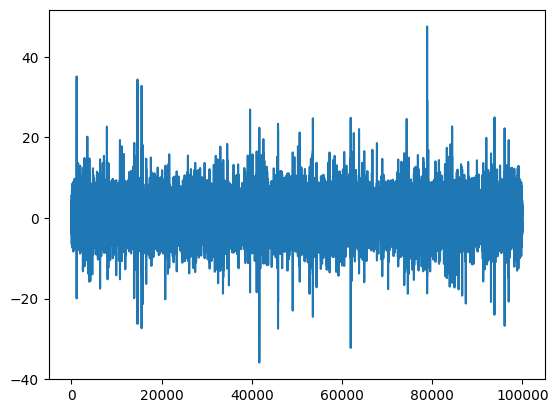

Параметры после оптимизации: alpha = 0.5046, beta_0 = 0.9940, beta_1 = 0.2939, gamma = 0.6059. Log-правдоподобие: -241864.8670.
Реальные параметры: alpha = 0.5, beta_0 = 1, beta_1 = 0.3, gamma = 0.6. Log-Правдоподобие при этих параметрах: -241866.3299.


In [9]:
# генерим данные 
alpha = 0.5
beta_0 = 1
beta_1 = 0.3
gamma = 0.6 
sigma_0sq = (beta_0 / (1 - beta_1 - gamma)) # попробуем делать массив sigma^2

z = norm.rvs(loc=0, scale=1, size=100000, random_state=42) # вектор z_t

# посчитаем массив sigma, epsilon
sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0 + beta_1 * epsilon[i - 1]**2 + gamma * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

# посчитаем массив y
y = []
for i in range(len(z)):
    y.append(alpha + epsilon[i])

plt.plot(y)
plt.show()

start_theta = [0.1, 0.1, 0.1, 0.1]


# ищем максимум правдоподобия

def optimize_function(theta):
    return -1 * calc_log_likelhood(t=100000, y=y, theta=theta)

result = minimize(optimize_function, start_theta, bounds=[(0.01, 0.6), (0, 1.5), (0, 0.34), (0, 0.64)])

print(f'Параметры после оптимизации: alpha = {result.x[0]:.4f}, beta_0 = {result.x[1]:.4f}, beta_1 = {result.x[2]:.4f}, gamma = {result.x[3]:.4f}. Log-правдоподобие: {-1 * result.fun:.4f}.')

true_log_likelhood = calc_log_likelhood(t=100000, y=y, theta=[0.5, 1, 0.3, 0.6])
print(f'Реальные параметры: alpha = {0.5}, beta_0 = {1}, beta_1 = {0.3}, gamma = {0.6}. Log-Правдоподобие при этих параметрах: {true_log_likelhood:.4f}.')

### 2. Модель с переключением

Обозначения: 

### Модель и обозначения: 
Задана марковская цепь $\{s_t\}$ с 2-мя состояниями $\{1, 2\}$.

$p_{11}, p_{12}, p_{21}, p_{22}$ -- переходные вероятности

$\xi_{1|0}$ -- вектор начального распределения   



Рассматриваем GARCH, параметры которого индексированы $\{s_t\}$:

$$y_t = \alpha^{s_t} + \varepsilon_t$$
$$\varepsilon_t = \sigma_t z_t$$
$$z_t \sim iid \mathcal{N}(0, 1)$$
$$\sigma_t^2 = \beta_0^{s_t} + \beta_1^{s_t} \epsilon_{t-1}^2 + \gamma^{s_t} \sigma_{t-1}^2$$


### Задача:
Дано: $(y_1, y_2, ..., y_T) = Y$ 

Оценить параметры $\theta_1 = (\alpha^1, \beta_0^1, \beta_1^1, \gamma^1)$, $\theta_2 = (\alpha^2, \beta_0^2, \beta_1^2, \gamma^2)$ 

## Генерация данных с марковским переключением


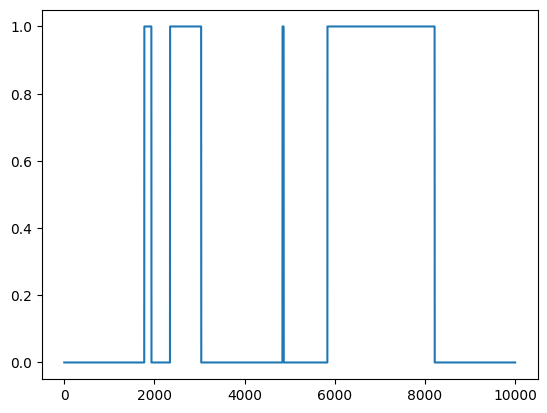

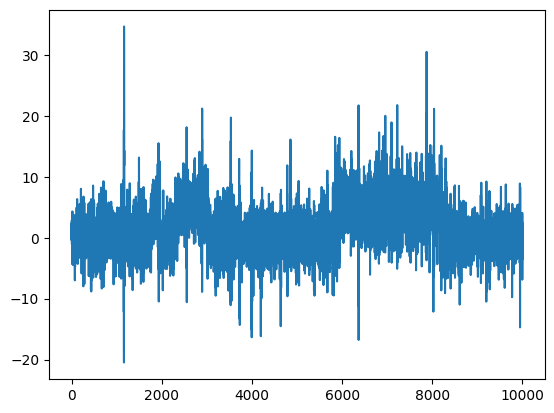

In [228]:
p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

import random 
s = [random.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(random.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(random.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 1 # начнем с 1

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(s)
plt.show()
plt.plot(y)
plt.show()


## Расчет правдоподобия 

План вычисления: 

1. $\sigma_0$ --- известно, можно вычислить $\varphi_{0}(y_0) = (\varphi_{0,1}(y_0), \varphi_{0, 1}(y_0))$ как плотность нормального распределения
2. $\xi_{0}$ --- начальное распределение МЦ


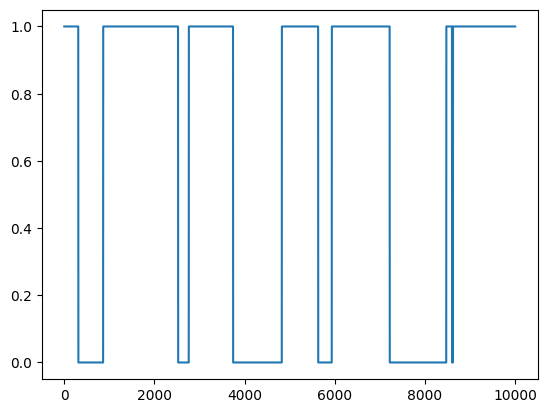

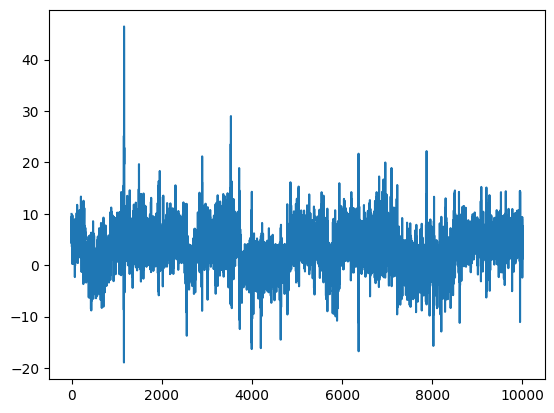

In [409]:
p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

import random 
s = [random.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(random.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(random.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 10 # начнем с 10

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(s)
plt.show()
plt.plot(y)
plt.show()


In [ ]:
def calc_logL(theta, sigma_0sq, y, t):

    alpha = [theta[0], theta[1]]
    beta_0 = [theta[2], theta[3]]
    beta_1 = [theta[4], theta[5]]
    gamma = [theta[6], theta[7]]

    xi_tt = []
    xi_ttm1 = [[0.5, 0.5]]
    phi = []
    sigmasq = [sigma_0sq]

    phi_0 = norm.pdf(y[0], loc=alpha[0], scale=sigmasq[0]**0.5)
    phi_1 = norm.pdf(y[0], loc=alpha[1], scale=sigmasq[0]**0.5)

    phi.append([phi_0, phi_1])

    dot_product = xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1]

    xi_0 = (phi[0][0] * xi_ttm1[0][0]) / dot_product
    xi_1 = (phi[0][1] * xi_ttm1[0][1]) / dot_product

    xi_tt.append([xi_0, xi_1])

    for i in range(1, t):
        
        xi_0 = xi_tt[i - 1][0] * p_11 + xi_tt[i - 1][1] * p_12 
        xi_1 = xi_tt[i - 1][0] * p_21 + xi_tt[i - 1][1] * p_22

        xi_ttm1.append([xi_0, xi_1])


        sigma_00sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[0])**2 + gamma[0]*sigmasq[i - 1]
        sigma_01sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[1])**2 + gamma[0]*sigmasq[i - 1]

        sigma_10sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[0])**2 + gamma[1]*sigmasq[i - 1]
        sigma_11sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[1])**2 + gamma[1]*sigmasq[i - 1]

        sigma_sq = xi_tt[i - 1][0] * (p_11 * (alpha[0]**2 + sigma_00sq) + p_12 * (alpha[1]**2 + sigma_01sq)) + xi_tt[i - 1][1] * (p_21 * (alpha[0]**2 + sigma_10sq) + p_22 * (alpha[1]**2 + sigma_11sq)) - (xi_ttm1[i][0] * alpha[0] + xi_ttm1[i][1] * alpha[1])**2

        sigmasq.append(sigma_sq)

        phi_0 = norm.pdf(y[i], loc=alpha[0], scale=sigmasq[i]**0.5)
        phi_1 = norm.pdf(y[i], loc=alpha[1], scale=sigmasq[i]**0.5)

        phi.append([phi_0, phi_1])
        
        dot_product = xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1]

        xi_0 = (phi[i][0] * xi_ttm1[i][0]) / dot_product
        xi_1 = (phi[i][1] * xi_ttm1[i][1]) / dot_product

        xi_tt.append([xi_0, xi_1])
    
    logL = 0
    for i in range(t):
        add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
        logL += add 

    return logL

In [413]:
theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

print(calc_logL(theta=theta_true, sigma_0sq=10, y=y, t=t))

-24763.012574581167


In [414]:
from scipy.optimize import minimize

start_theta = [-0.1, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

def optimize_function(theta):
    return -1 * calc_logL(theta=theta, sigma_0sq=10, y=y, t=t)

result = minimize(optimize_function, start_theta, bounds=[(-0.1, 0.5), (4.7, 5.2), (0.8, 1.1), (0.9, 1.2), (0.25, 0.31), (0.25, 0.32), (0.57, 0.61), (0.59, 0.62)])

print(result.x)
print(calc_logL(result.x, sigma_0sq=10, y=y, t=t))

[-0.02554451  5.00537949  1.00967109  1.16882901  0.27246033  0.28490348
  0.60841131  0.59      ]
-24754.770645781886


In [408]:
print(calc_logL(result.x, sigma_0sq=10, y=y, t=t))

-2463086.003664332


## Пробую ускорить вычисление

In [2]:
def calc_logL_fast(theta, sigma_0sq, y, t):

    alpha = [theta[0], theta[1]]
    beta_0 = [theta[2], theta[3]]
    beta_1 = [theta[4], theta[5]]
    gamma = [theta[6], theta[7]]

    xi_tt = []
    xi_ttm1 = [[0.5, 0.5]]
    phi = []
    sigmasq = [sigma_0sq]

    phi_0 = norm.pdf(y[0], loc=alpha[0], scale=sigmasq[0]**0.5)
    phi_1 = norm.pdf(y[0], loc=alpha[1], scale=sigmasq[0]**0.5)

    phi.append([phi_0, phi_1])

    dot_product = xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1]

    xi_0 = (phi[0][0] * xi_ttm1[0][0]) / dot_product
    xi_1 = (phi[0][1] * xi_ttm1[0][1]) / dot_product

    xi_tt.append([xi_0, xi_1])

    logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])

    for i in range(1, t):
        
        xi_0 = xi_tt[i - 1][0] * p_11 + xi_tt[i - 1][1] * p_12 
        xi_1 = xi_tt[i - 1][0] * p_21 + xi_tt[i - 1][1] * p_22

        xi_ttm1.append([xi_0, xi_1])


        sigma_00sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[0])**2 + gamma[0]*sigmasq[i - 1]
        sigma_01sq = beta_0[0] + beta_1[0] * (y[i - 1] - alpha[1])**2 + gamma[0]*sigmasq[i - 1]

        sigma_10sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[0])**2 + gamma[1]*sigmasq[i - 1]
        sigma_11sq = beta_0[1] + beta_1[1] * (y[i - 1] - alpha[1])**2 + gamma[1]*sigmasq[i - 1]

        sigma_sq = xi_tt[i - 1][0] * (p_11 * (alpha[0]**2 + sigma_00sq) + p_12 * (alpha[1]**2 + sigma_01sq)) + xi_tt[i - 1][1] * (p_21 * (alpha[0]**2 + sigma_10sq) + p_22 * (alpha[1]**2 + sigma_11sq)) - (xi_ttm1[i][0] * alpha[0] + xi_ttm1[i][1] * alpha[1])**2

        sigmasq.append(sigma_sq)

        phi_0 = norm.pdf(y[i], loc=alpha[0], scale=sigmasq[i]**0.5)
        phi_1 = norm.pdf(y[i], loc=alpha[1], scale=sigmasq[i]**0.5)

        phi.append([phi_0, phi_1])
        
        dot_product = xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1]

        xi_0 = (phi[i][0] * xi_ttm1[i][0]) / dot_product
        xi_1 = (phi[i][1] * xi_ttm1[i][1]) / dot_product

        xi_tt.append([xi_0, xi_1])
    
        add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
        logL += add 

    return logL

In [3]:
theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

print(calc_logL_fast(theta=theta_true, sigma_0sq=10, y=y, t=t))

NameError: name 'y' is not defined

In [8]:
from scipy.optimize import minimize

start_theta = [-0.1, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

def optimize_function(theta):
    return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y, t=t)

result = minimize(optimize_function, start_theta, bounds=[(-0.1, 0.5), (4.7, 5.2), (0.8, 1.1), (0.9, 1.2), (0.25, 0.31), (0.25, 0.32), (0.57, 0.61), (0.59, 0.62)])

print(result.x)

print(calc_logL_fast(result.x, sigma_0sq=10, y=y, t=t))

[-0.1        4.7        0.9532871  0.9        0.25       0.25
  0.57       0.59     ]
-237.6289277933232


# Моделирую сходимость

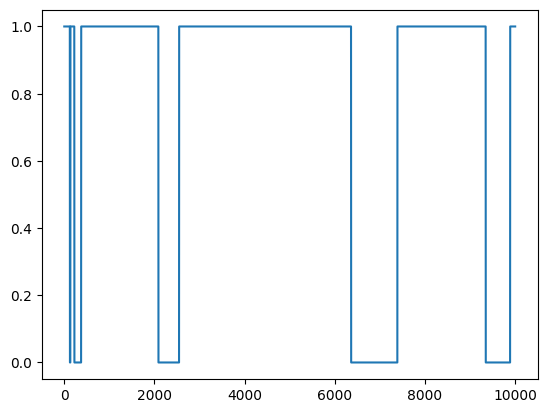

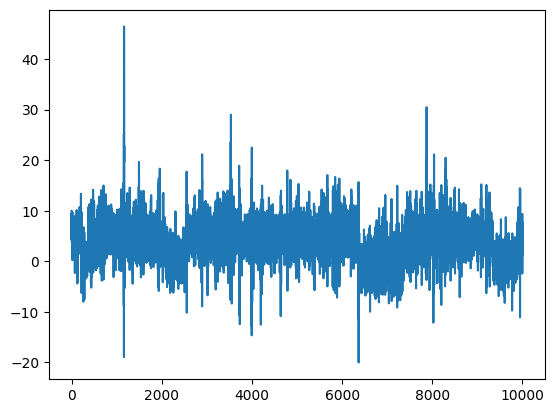

In [24]:
p_11, p_12, p_21, p_22 = 0.999, 0.001, 0.001, 0.999
t = 10000
xi_0 = [0.5, 0.5]

import random 
s = [random.choices([0, 1], weights=xi_0)[0]]
for i in range(1, t):
    if s[i - 1] == 0: s.append(random.choices([0, 1], weights=[p_11, p_12])[0])
    else: s.append(random.choices([0, 1], weights=[p_21, p_22])[0])

alpha = [0, 5]
beta_0 = [1, 1.001]
beta_1 = [0.3, 0.31]
gamma = [0.6, 0.61]

sigma_0sq = 10 # начнем с 10

z = norm.rvs(loc=0, scale=1, size=t, random_state=42) # вектор z_t


sigmasq = [sigma_0sq]
epsilon = [sigmasq[0] * z[0]]
for i in range(1, len(z)):
    sigmasq.append(beta_0[s[i]] + beta_1[s[i]] * epsilon[i - 1]**2 + gamma[s[i]] * sigmasq[i - 1])
    epsilon.append((sigmasq[i] ** 0.5) * z[i])

y = []
for i in range(len(z)):
    y.append(alpha[s[i]] + epsilon[i])


plt.plot(s)
plt.show()
plt.plot(y)
plt.show()


In [25]:
count_arr = [10*i for i in range(1, 1001)]
len(count_arr)

1000

In [26]:
from tqdm import tqdm

theta_estimated = [[] for x in range(8)]

theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

start_theta = [-0.3, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]



for t in tqdm(count_arr):
    start_theta = [-0.1, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

    def optimize_function(theta):
        return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y[:t], t=t)

    result = minimize(optimize_function, start_theta, bounds=[(-0.1, 0.5), (4.7, 5.2), (0.8, 1.1), (0.9, 1.2), (0.25, 0.31), (0.25, 0.32), (0.57, 0.61), (0.59, 0.62)])

    for i in range(8):
        theta_estimated[i].append(result.x[i])

100%|██████████| 1000/1000 [16:43:38<00:00, 60.22s/it]  


In [27]:
theta_estimated[i]

[np.float64(0.59),
 np.float64(0.595182991230922),
 np.float64(0.59),
 np.float64(0.6034143080138394),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.59),
 np.float64(0.62),
 np.float64(0.62),
 np.float64(0.6151756873081538),
 np.float64(0.6078039528361756),
 np.float64(0.6098279858457596),
 np.float64(0.6051091909969082),
 np.float64(0.5984831177497524),
 np.float64(0.5912414504972368),
 np.float64(0.6094878261278671),
 np.float64(0.5995897178066889),
 np.float64(0.6145262300315972),
 np.float64(0.6016607165601342),
 np.float64(0.6002743064275916),
 np.float64(0.5991800665143633),
 np.float64(0.5912005413293954),
 np.float64(0.5931959432864766),
 np.float64(0.5971041120707181),
 np.float64(0.5980026950559512),
 np.float64(0.5997418721285579),
 np.float64(0.6014598981429677),
 np.float64(0.6020844990701277),
 np.float64(0.6011701177249309),
 np.float64(0.5998223290595789),
 np.float64(0.

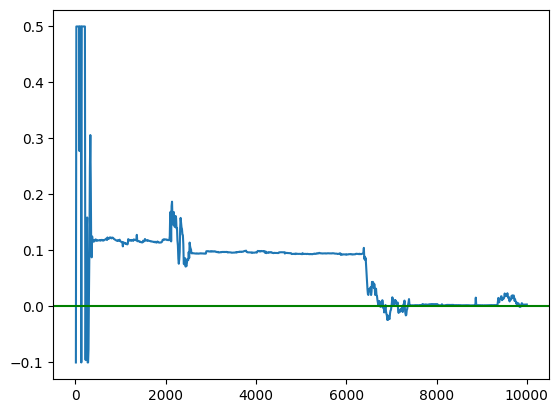

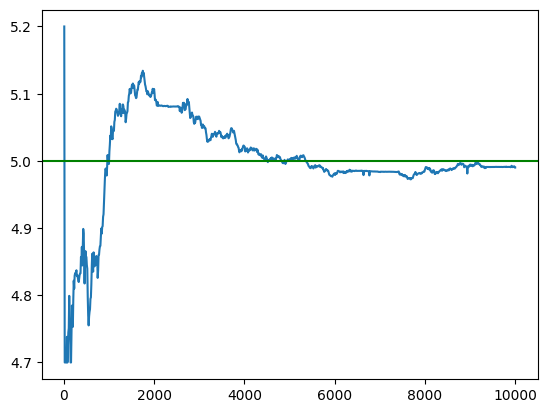

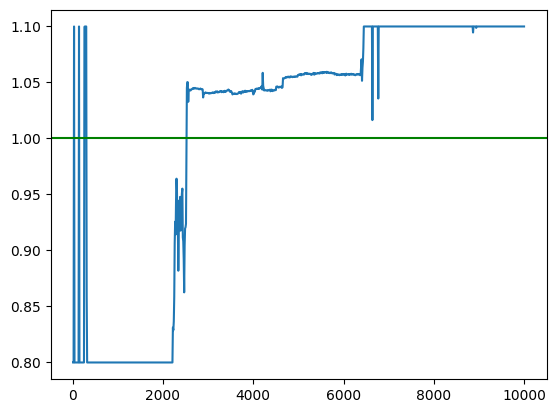

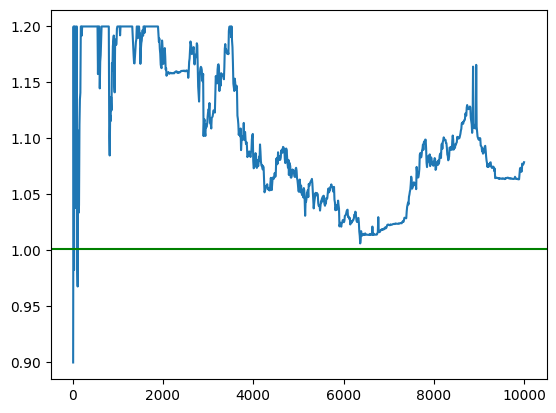

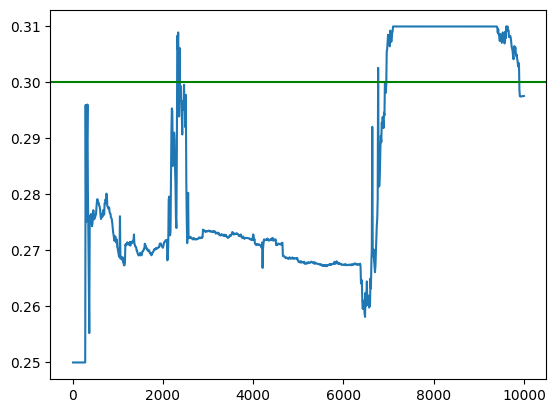

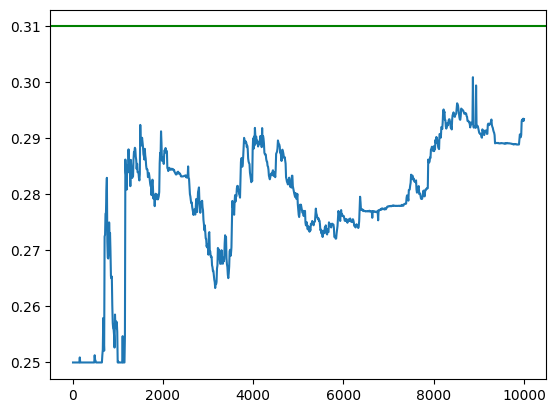

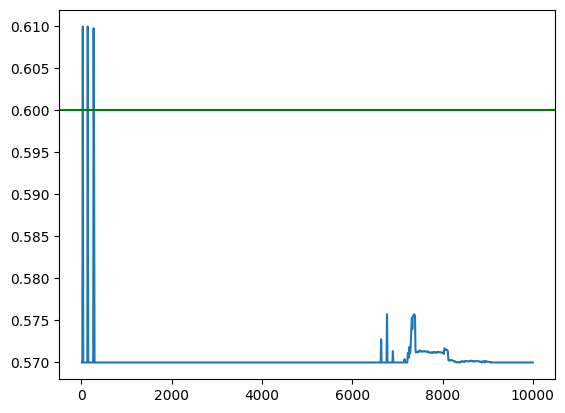

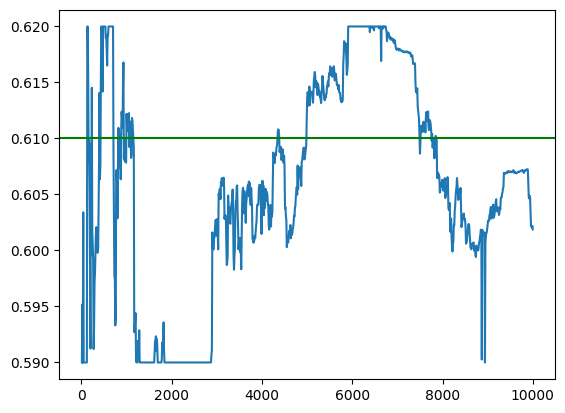

In [ ]:
for i in range(8):
    plt.plot(count_arr,theta_estimated[i])
    plt.axhline(theta_true[i], color='g')
    plt.show()

In [ ]:
from tqdm import tqdm

theta_true = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]

# start_theta = [-0.3, 4.7, 0.8, 0.9, 0.25, 0.25, 0.57, 0.59]

alpha_1_estimated = []

for t in tqdm(count_arr):
    start_alpha = 0.1

    def optimize_function(alpha_1):
        theta = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]
        theta[0] = alpha_1
        return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y[:t], t=t)

    result = minimize(optimize_function, start_alpha, bounds=[(-0.3, 0.3)])
    alpha_1_estimated.append(result.x[0])


# start_alpha = 0.1

# def optimize_function(alpha_1):
#     theta = [0, 5, 1, 1.001, 0.3, 0.31, 0.6, 0.61]
#     theta[0] = alpha_1
#     return -1 * calc_logL_fast(theta=theta, sigma_0sq=10, y=y[:t], t=t)

# result = minimize(optimize_function, start_alpha, bounds=[(-0.5, 0.5)])

# print(result.x)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/_8/qj_zjpkx18bcv75rjs72zckh0000gn/T/ipykernel_44160/2662196723.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logL = m.log(xi_ttm1[0][0] * phi[0][0] + xi_ttm1[0][1] * phi[0][1])
/var/folders/_8/qj_zjpkx18bcv75rjs72zckh0000gn/T/ipykernel_44160/2662196723.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  add = m.log(xi_ttm1[i][0] * phi[i][0] + xi_ttm1[i][1] * phi[i][1])
 49%|████▉     | 488/1000 [11:32<12:07,  1.42s/it]  


KeyboardInterrupt: 

In [34]:
alpha_1_estimated

[np.float64(-0.3),
 np.float64(0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(-0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(-0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.3),
 np.float64(0.26315186144981034),
 np.float64(0.2778136973340309),
 np.float64(-0.042824787314873304),
 np.float64(-0.05455551502707596),
 np.float64(0.005463650449478801),
 np.float64(0.0930881718033334),
 np.float64(0.13929466965858928),
 np.float64(0.27312628263613353),
 np.float64(0.3),
 np.float64(0.24399840487102284),
 np.float64(0.11703217230790128),
 np.float64(0.11034426162542459),
 np.float64(0.14558015861961698),
 np.float64(0.14742116318688625),
 np.float64(0.1470921984890323),
 np.float64(0.14688008245049916),
 np.float64(0.1471828786333247

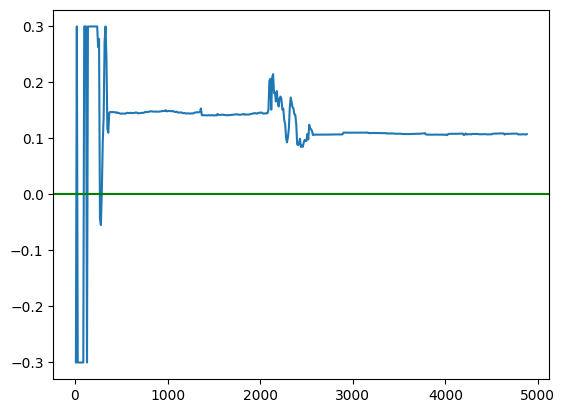

In [36]:
plt.plot(count_arr[:len(alpha_1_estimated)],alpha_1_estimated)
plt.axhline(theta_true[0], color='g')
plt.show()